# Анализ ордербука

In [ ]:
# Декомпозиция класса

In [54]:
from typing import Dict, Any, List

class OrderBookOutOfSync(Exception):
    pass

class OrderBook:
    def __init__(self):
        # books: symbol -> {'timestamp': float, 'bids': {price_str: volume}, 'asks': {price_str: volume}}
        self.books: Dict[str, Dict[str, Any]] = {}
        self.last_update: Dict[str, int] = {}

    def process_message(self, message: Dict[str, Any]) -> None:
        data = message['data']
        symbol = data['s']
        ts = message.get('ts', 0.0)

        if message['type'] == 'snapshot':
            self.books[symbol] = {
                'timestamp': ts,
                'bids': {str(float(p[0])): float(p[1]) for p in data['b']},
                'asks': {str(float(p[0])): float(p[1]) for p in data['a']},
            }
            self.last_update[symbol] = int(data.get('u', 0))
        elif message['type'] == 'delta':
            update_id = int(data['u'])
            prev_update = self.last_update.get(symbol)
            if prev_update is None:
                return
            if update_id != prev_update + 1:
                raise OrderBookOutOfSync(
                    f"Update out of sequence for {symbol}: expected {prev_update + 1}, got {update_id}"
                )

            if symbol not in self.books:
                return

            def update_side(side_name: str, updates: List[List[Any]]):
                for entry in updates:
                    try:
                        price_f = float(entry[0])
                        volume_f = float(entry[1])
                    except (ValueError, TypeError, IndexError):
                        continue
                    price_key = str(price_f)
                    if volume_f > 0:
                        self.books[symbol][side_name][price_key] = volume_f
                    elif price_key in self.books[symbol][side_name]:
                        del self.books[symbol][side_name][price_key]

            update_side("bids", data.get("b", []))
            update_side("asks", data.get("a", []))

            self.last_update[symbol] = update_id
            self.books[symbol]["timestamp"] = ts

    def _get_basic_info(self, symbol: str) -> Dict[str, Any]:
        """Получить поля symbol, timestamp, lowest_ask, highest_bid для symbol."""
        if symbol not in self.books:
            return {"symbol": symbol, "timestamp": None, "lowest_ask": None, "highest_bid": None}
        bids = self.books[symbol]["bids"]
        asks = self.books[symbol]["asks"]
        lowest_ask = min(map(float, asks.keys())) if asks else None
        highest_bid = max(map(float, bids.keys())) if bids else None
        timestamp = self.books[symbol].get("timestamp")
        return {
            "symbol": symbol,
            "timestamp": timestamp,
            "lowest_ask": lowest_ask,
            "highest_bid": highest_bid,
        }

    def get_order_book(self, symbol: str) -> Dict[str, Any]:
        base_info = self._get_basic_info(symbol)
        if symbol not in self.books:
            return {**base_info, "bids": {}, "asks": {}}
        bids = self.books[symbol]["bids"]
        asks = self.books[symbol]["asks"]
        sorted_bids = dict(sorted(bids.items(), key=lambda x: float(x[0]), reverse=True))
        sorted_asks = dict(sorted(asks.items(), key=lambda x: float(x[0])))
        return {**base_info, "bids": sorted_bids, "asks": sorted_asks}

    def get_aggregated_levels(self, symbol: str, levels: List[float]) -> Dict[str, Any]:
        base_info = self._get_basic_info(symbol)
        if symbol not in self.books:
            return {**base_info, "bids": [], "asks": []}
        bids = self.books[symbol]["bids"]
        asks = self.books[symbol]["asks"]
        if not bids or not asks:
            return {**base_info, "bids": [], "asks": []}

        highest_bid = base_info["highest_bid"]
        lowest_ask = base_info["lowest_ask"]

        sorted_bids = sorted(((float(price), volume) for price, volume in bids.items()), reverse=True)
        sorted_asks = sorted(((float(price), volume) for price, volume in asks.items()))

        def aggregate_levels(
            sorted_prices_volumes: List, base_price: float, percents: List[float], is_bid: bool
        ) -> List[Dict[str, Any]]:
            agg_results = []
            for pct in percents:
                pct = float(pct)
                if is_bid:
                    lower_bound = base_price * (1 - pct / 100)
                    volume_sum = sum(
                        volume
                        for price, volume in sorted_prices_volumes
                        if base_price > price > lower_bound
                    )
                else:
                    upper_bound = base_price * (1 + pct / 100)
                    volume_sum = sum(
                        volume
                        for price, volume in sorted_prices_volumes
                        if base_price < price < upper_bound
                    )
                agg_results.append({"level": pct, "volume": volume_sum})
            return agg_results

        aggregated_bids = aggregate_levels(sorted_bids, highest_bid, levels, True)
        aggregated_asks = aggregate_levels(sorted_asks, lowest_ask, levels, False)

        return {**base_info, "bids": aggregated_bids, "asks": aggregated_asks}


In [139]:
from typing import Dict, Any, List, Optional
import time

class OrderBookOutOfSync(Exception):
    pass

class VolumeDeltaOrderBook:
    def __init__(self, max_depth_sec: int = 900):
        self.max_depth_sec = max_depth_sec
        # Сохраняем историю объёмов: symbol -> side -> list записей {timestamp, in, out}
        self.volume_history: Dict[str, Dict[str, List[Dict[str, float]]]] = {}
        # Запоминаем последнее время обновления для каждого symbol
        self.last_update_time: Dict[str, float] = {}
        # Для хранения текущего объёма по каждому symbol и side (по цене)
        self.current_volumes: Dict[str, Dict[str, Dict[str, float]]] = {}
        # Последние id обновления message для контроля последовательности
        self._last_update_id: Dict[str, int] = {}

    def process_message(self, message: Dict[str, Any]) -> None:
        data = message['data']
        symbol = data['s']
        # Используем время получения сообщения как timestamp для истории
        now_ts = time.time()

        if message['type'] == 'snapshot':
            self.volume_history[symbol] = {'bids': [], 'asks': []}
            self.last_update_time[symbol] = now_ts
            self.current_volumes[symbol] = {'bids': {}, 'asks': {}}
            self._last_update_id[symbol] = int(data.get('u', 0))

            # Инициализируем текущие объемы из snapshot
            for side_name in ['bids', 'asks']:
                side_updates = data.get(side_name[0], data.get(side_name, []))  # data['b'] or data['a'] обычно
                for price_str, volume in side_updates:
                    price = str(float(price_str))
                    self.current_volumes[symbol][side_name][price] = float(volume)

        elif message['type'] == 'delta':
            update_id = int(data['u'])
            prev_update = self._last_update_id.get(symbol)
            if prev_update is None:
                # Без snapshot не обрабатывать delta
                return
            if update_id != prev_update + 1:
                raise OrderBookOutOfSync(f"Update out of sequence for {symbol}: expected {prev_update+1}, got {update_id}")

            if symbol not in self.volume_history:
                self.volume_history[symbol] = {'bids': [], 'asks': []}
            if symbol not in self.current_volumes:
                self.current_volumes[symbol] = {'bids': {}, 'asks': {}}
            if symbol not in self.last_update_time or now_ts > self.last_update_time[symbol]:
                self.last_update_time[symbol] = now_ts

            def update_side(side_name: str, updates: List[List[float]]):
                volume_in = 0.0
                volume_out = 0.0
                side_current = self.current_volumes[symbol][side_name]

                for entry in updates:
                    try:
                        price_f = float(entry[0])
                        volume_f = float(entry[1])
                    except (ValueError, TypeError, IndexError):
                        continue

                    price_key = str(price_f)
                    prev_volume = side_current.get(price_key, 0.0)
                    delta_volume = volume_f - prev_volume
                    delta_value = price_f * delta_volume

                    if delta_volume > 0:
                        volume_in += delta_value
                    elif delta_volume < 0:
                        volume_out += abs(delta_value)

                    if volume_f > 0:
                        side_current[price_key] = volume_f
                    elif price_key in side_current:
                        del side_current[price_key]

                # Запись с теперь актуальным timestamp
                self.volume_history[symbol][side_name].append({
                    'timestamp': now_ts,
                    'in': volume_in,
                    'out': volume_out
                })

                cutoff = now_ts - self.max_depth_sec
                self.volume_history[symbol][side_name] = [
                    rec for rec in self.volume_history[symbol][side_name]
                    if rec['timestamp'] >= cutoff
                ]

            update_side('bids', data.get('b', []))
            update_side('asks', data.get('a', []))

            self._last_update_id[symbol] = update_id

    def get_volume_delta(self, symbol: str, depth_sec: int) -> Optional[Dict[str, Any]]:
        if symbol not in self.volume_history:
            return None
        depth_sec = min(depth_sec, self.max_depth_sec)
        now_ts = self.last_update_time.get(symbol, time.time())
        cutoff = now_ts - depth_sec

        def sum_volume(records: List[Dict[str, float]]):
            volume_in = sum(r['in'] for r in records if r['timestamp'] >= cutoff)
            volume_out = sum(r['out'] for r in records if r['timestamp'] >= cutoff)
            return {'in': volume_in, 'out': volume_out}

        bids = sum_volume(self.volume_history[symbol]['bids'])
        asks = sum_volume(self.volume_history[symbol]['asks'])

        return {
            'symbol': symbol,
            'timestamp': now_ts,
            'depth': depth_sec,
            'bids': bids,
            'asks': asks,
        }


In [140]:
levels[3]

{'symbol': 'BTCUSDT',
 'timestamp': 1756684801829,
 'lowest_ask': 108241.8,
 'highest_bid': 108241.7,
 'bids': [{'level': 0.005, 'volume': 0.024432999999999996},
  {'level': 0.01, 'volume': 0.720067},
  {'level': 0.015, 'volume': 2.188207},
  {'level': 0.02, 'volume': 3.6439869999999983}],
 'asks': [{'level': 0.005, 'volume': 0.12923800000000002},
  {'level': 0.01, 'volume': 1.229285},
  {'level': 0.015, 'volume': 2.2872159999999995},
  {'level': 0.02, 'volume': 3.177030999999999}]}

In [176]:
import json

def process_json_lines(file_path, handler):
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # пропуск пустых строк
            try:
                obj = json.loads(line)
            except json.JSONDecodeError as e:
                print(f"Ошибка декодирования JSON: {e}, строка: {line}")
                continue
            handler(obj)


ob = OrderBook()
volob = VolumeDeltaOrderBook()

orderbooks = []
levels = []
volumes = []
# пример обработчика
def my_handler(json_obj):
    #print(json_obj)  # здесь можно делать что угодно с объектом
    ob.process_message(json_obj)
    orderbooks.append(ob.get_order_book("BTCUSDT"))
    levels.append(ob.get_aggregated_levels("BTCUSDT", [0.005,0.01, 0.015, 0.02]))
    volob.process_message(json_obj)
    volumes.append(volob.get_volume_delta("BTCUSDT", 60))


# пример вызова
#process_json_lines('./data/2025-09-01_BTCUSDT_ob200.data', my_handler)
process_json_lines('./data/testob2.csv', my_handler)

In [142]:
volumes

[{'symbol': 'BTCUSDT',
  'timestamp': 1760385335.823819,
  'depth': 10,
  'bids': {'in': 0, 'out': 0},
  'asks': {'in': 0, 'out': 0}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760385335.824225,
  'depth': 10,
  'bids': {'in': 267825.1921611, 'out': 144300.90123040005},
  'asks': {'in': 162848.7712041, 'out': 193219.8091764}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760385335.824451,
  'depth': 10,
  'bids': {'in': 434006.80804489995, 'out': 353783.707776},
  'asks': {'in': 403914.7605707, 'out': 277329.900226}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760385335.824672,
  'depth': 10,
  'bids': {'in': 707685.6404085999, 'out': 1136577.1175236},
  'asks': {'in': 657794.1375483, 'out': 613306.2864753001}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760385335.824901,
  'depth': 10,
  'bids': {'in': 1087650.2383775997, 'out': 1401142.0233726},
  'asks': {'in': 934629.9921611999, 'out': 899587.3122018}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760385335.8253162,
  'depth': 10,
  'bids': {'in': 139479

In [177]:
import numpy as np
import pandas as pd

In [191]:
prices = np.array([volume["lowest_ask"] for volume in orderbooks])

bids_in = np.array([volume["bids"]["in"] for volume in volumes])
bids_out = np.array([volume["bids"]["out"] for volume in volumes])
asks_in = np.array([volume["asks"]["in"] for volume in volumes])
asks_out = np.array([volume["asks"]["out"] for volume in volumes])


bids_balance = bids_in - bids_out
asks_balance = asks_in - asks_out
balance = bids_in - asks_out

x = np.array([vol["timestamp"] for vol in volumes])

data=np.concatenate([prices.reshape(-1,1), bids_in.reshape(-1,1), bids_out.reshape(-1,1), asks_in.reshape(-1,1), asks_out.reshape(-1,1)], axis=1)
df = pd.DataFrame(data=data,index=x, columns= ["prices", "bids_in", "bids_out", "asks_in", "asks_out"] )


In [192]:
volumes

[{'symbol': 'BTCUSDT',
  'timestamp': 1760386603.880457,
  'depth': 60,
  'bids': {'in': 0, 'out': 0},
  'asks': {'in': 0, 'out': 0}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760386603.880766,
  'depth': 60,
  'bids': {'in': 267825.1921611, 'out': 144300.90123040005},
  'asks': {'in': 162848.7712041, 'out': 193219.8091764}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760386603.880943,
  'depth': 60,
  'bids': {'in': 434006.80804489995, 'out': 353783.707776},
  'asks': {'in': 403914.7605707, 'out': 277329.900226}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760386603.881129,
  'depth': 60,
  'bids': {'in': 707685.6404085999, 'out': 1136577.1175236},
  'asks': {'in': 657794.1375483, 'out': 613306.2864753001}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760386603.88133,
  'depth': 60,
  'bids': {'in': 1087650.2383775997, 'out': 1401142.0233726},
  'asks': {'in': 934629.9921611999, 'out': 899587.3122018}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1760386603.8817239,
  'depth': 60,
  'bids': {'in': 1394798

In [193]:
df

prices       bids_in      bids_out       asks_in      asks_out
1.760387e+09  108241.8  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1.760387e+09  108241.8  2.678252e+05  1.443009e+05  1.628488e+05  1.932198e+05
1.760387e+09  108241.8  4.340068e+05  3.537837e+05  4.039148e+05  2.773299e+05
1.760387e+09  108241.8  7.076856e+05  1.136577e+06  6.577941e+05  6.133063e+05
1.760387e+09  108241.8  1.087650e+06  1.401142e+06  9.346300e+05  8.995873e+05
...                ...           ...           ...           ...           ...
1.760387e+09  108051.2  3.233035e+09  3.233369e+09  2.277799e+09  2.277480e+09
1.760387e+09  108051.2  3.231694e+09  3.230802e+09  2.276732e+09  2.276959e+09
1.760387e+09  108051.2  3.229242e+09  3.228448e+09  2.275218e+09  2.275055e+09
1.760387e+09  108051.2  3.228506e+09  3.227429e+09  2.274817e+09  2.274877e+09
1.760387e+09  108051.2  3.227490e+09  3.226601e+09  2.274270e+09  2.274377e+09

[20781 rows x 5 columns]

In [194]:
x[999]

1760386604.171396

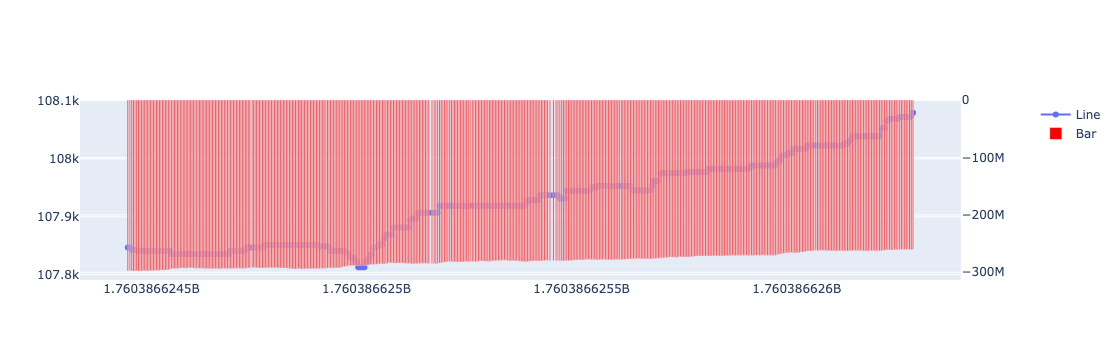

In [195]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


start_idx = 12200
end_idx = start_idx+500

# Создаем субграфики с двойной вертикальной осью
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=x[start_idx:end_idx], y=prices[start_idx:end_idx], mode='lines+markers', name="Line"),secondary_y=False,)
fig.add_trace(go.Bar(x=x[start_idx:end_idx], y=balance[start_idx:end_idx], name="Bar", marker_color='red',), secondary_y=True,)
fig.show()


In [57]:
orderbooks[:3]

[{'symbol': 'BTCUSDT',
  'timestamp': 1756684801229,
  'lowest_ask': 108241.8,
  'highest_bid': 108241.7,
  'bids': {'108241.7': 1.041892,
   '108240.1': 0.003,
   '108239.7': 0.000433,
   '108239.3': 0.039114,
   '108239.2': 0.098379,
   '108239.1': 0.003,
   '108237.7': 0.009,
   '108237.4': 0.13,
   '108237.3': 0.006,
   '108237.2': 0.03,
   '108236.9': 0.191506,
   '108236.8': 0.092382,
   '108236.7': 0.003,
   '108236.4': 0.004618,
   '108236.3': 0.006,
   '108236.2': 0.003,
   '108235.9': 0.03,
   '108235.6': 0.0001,
   '108235.2': 0.151,
   '108235.1': 0.03,
   '108234.4': 0.009,
   '108233.8': 0.408,
   '108233.6': 0.003461,
   '108233.4': 0.006,
   '108233.0': 0.148618,
   '108232.9': 0.03,
   '108232.6': 7e-05,
   '108232.4': 0.003,
   '108232.2': 0.001955,
   '108231.9': 0.288791,
   '108231.3': 0.069819,
   '108231.0': 0.132945,
   '108230.9': 0.142,
   '108230.8': 0.06,
   '108230.7': 0.029947,
   '108230.2': 0.147592,
   '108228.7': 0.262945,
   '108228.6': 0.03,
   '1082

In [58]:
levels[:3]

[{'symbol': 'BTCUSDT',
  'timestamp': 1756684801229,
  'lowest_ask': 108241.8,
  'highest_bid': 108241.7,
  'bids': [{'level': 0.005, 'volume': 0.616432},
   {'level': 0.01, 'volume': 2.074191},
   {'level': 0.015, 'volume': 3.83113},
   {'level': 0.02, 'volume': 5.3622510000000005}],
  'asks': [{'level': 0.005, 'volume': 0},
   {'level': 0.01, 'volume': 0.588364},
   {'level': 0.015, 'volume': 1.7815260000000002},
   {'level': 0.02, 'volume': 2.399791}]},
 {'symbol': 'BTCUSDT',
  'timestamp': 1756684801430,
  'lowest_ask': 108241.8,
  'highest_bid': 108241.7,
  'bids': [{'level': 0.005, 'volume': 0.6976190000000001},
   {'level': 0.01, 'volume': 2.133136},
   {'level': 0.015, 'volume': 3.896806999999999},
   {'level': 0.02, 'volume': 5.195621999999999}],
  'asks': [{'level': 0.005, 'volume': 0.011498},
   {'level': 0.01, 'volume': 0.7739370000000001},
   {'level': 0.015, 'volume': 2.10604},
   {'level': 0.02, 'volume': 2.909042}]},
 {'symbol': 'BTCUSDT',
  'timestamp': 1756684801629,


In [59]:
volumes[:3]

[{'symbol': 'BTCUSDT',
  'timestamp': 1756684801229,
  'lowest_ask': 108241.8,
  'highest_bid': 108241.7,
  'depth': 10,
  'bids': {'in': 0.0, 'out': 0.0},
  'asks': {'in': 0.0, 'out': 0.0}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1756684801229,
  'lowest_ask': 108241.8,
  'highest_bid': 108241.7,
  'depth': 10,
  'bids': {'in': 267825.1921611, 'out': 144300.90123040005},
  'asks': {'in': 162848.7712041, 'out': 193219.8091764}},
 {'symbol': 'BTCUSDT',
  'timestamp': 1756684801229,
  'lowest_ask': 108241.8,
  'highest_bid': 108241.7,
  'depth': 10,
  'bids': {'in': 166181.6158838, 'out': 209482.80654559997},
  'asks': {'in': 241065.9893666, 'out': 84110.0910496}}]